In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Molecules 

In [45]:
from SCFInitialGuess.utilities.dataset import ScreenedData

target = "P"
basis = "6-311++g**"

data = ScreenedData(r_max=10)

data.include(data_path = "../../thesis/dataset/MethanT/", postfix = "MethanT", target=target)

In [46]:
#data = Data()

#data.include(data_path = "../../dataset/MethanT/", postfix = "MethanT", target=target)
data.include(data_path = "../../thesis/dataset/MethanT2/", postfix = "MethanT2", target=target)
data.include(data_path = "../../thesis/dataset/MethanT3/", postfix = "MethanT3", target=target)
data.include(data_path = "../../thesis/dataset/MethanT4/", postfix = "MethanT4", target=target)

data.include(data_path = "../../thesis/dataset/EthanT/",  postfix = "EthanT", target=target)
data.include(data_path = "../../thesis/dataset/EthanT2/", postfix = "EthanT2", target=target)
data.include(data_path = "../../thesis/dataset/EthanT3/", postfix = "EthanT3", target=target)

data.include(data_path = "../../thesis/dataset/EthenT/",  postfix = "EthenT", target=target)
data.include(data_path = "../../thesis/dataset/EthenT2/", postfix = "EthenT2", target=target)
data.include(data_path = "../../thesis/dataset/EthenT3/", postfix = "EthenT3", target=target)

data.include(data_path = "../../thesis/dataset/EthinT/",  postfix = "EthinT", target=target)
data.include(data_path = "../../thesis/dataset/EthinT2/", postfix = "EthinT2", target=target)
data.include(data_path = "../../thesis/dataset/EthinT3/", postfix = "EthinT3", target=target)

# Descriptor 

In [47]:
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import RADIAL_GAUSSIAN_MODELS, make_uniform
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, SPHAngularDescriptor
import pickle

model = make_uniform(25, 5, eta_max=60, eta_min=20)

descriptor = AtomicNumberWeighted(
    Gaussians(*model),
    SPHAngularDescriptor(4),
    BehlerCutoff1(5)
)

#pickle.dump(descriptor, open(model_path + "descriptor.dump", "wb"))
    
descriptor.radial_descriptor.number_of_descriptors, descriptor.angular_descriptor.number_of_descriptors, descriptor.number_of_descriptors

(25, 50, 75)

# Package Dataset 

In [48]:
from SCFInitialGuess.utilities.dataset import make_block_dataset, extract_HOMO_block_dataset_pairs

dataset = make_block_dataset(
    descriptor,
    data.molecules,
    data.T,
    "H",
    extract_HOMO_block_dataset_pairs
)

#np.save(model_path + "normalisation.npy", (dataset.x_mean, dataset.x_std))


In [38]:
len(dataset.training[0]), len(dataset.validation[0]), len(dataset.testing[0]), 

(3840, 960, 1206)

In [14]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

species = "H"
dim = N_BASIS[basis][species]
dim_triu = dim * (dim + 1) // 2

# NN Utils 

In [9]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(5e-3)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mse']
    )
    
    return model



In [30]:

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-8, 
    patience=20, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=2, 
    min_lr=1e-10
)


epochs = 1000


def train_model(model, dataset, filepath=None, learning_rate=1e-4, log_dir=None):

    if not log_dir is None:
        tensorboard = keras.callbacks.TensorBoard(
            log_dir=log_dir, 
            histogram_freq=0, 
            batch_size=32, 
            #update_freq='epoch'
        )
    
    if not filepath is None:
        checkpoint = keras.callbacks.ModelCheckpoint(
            filepath, 
            monitor='val_mean_squared_error', 
            verbose=1, 
            save_best_only=True, 
            save_weights_only=False, 
            mode='auto', 
            period=1
        )
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    train, validation = [], []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                #checkpoint,
                #tensorboard
            ]
        )
            
        
        #error.append(model.evaluate(
        #    dataset.testing[0], 
        #    dataset.testing[1], 
        #    verbose=1
        #)[1])
    
    return error
    

# Training 

In [41]:
dataset.training[0].shape, dataset.training[1].shape

((3840, 150), (3840, 49))

In [31]:
descriptor.number_of_descriptors, dim**2

(75, 49)

In [32]:
structure = [100, 70]

In [51]:
keras.backend.clear_session()

In [52]:
model = make_model(
    structure=structure,
    input_dim=descriptor.number_of_descriptors * 2,
    output_dim=dim**2,
    
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               15100     
_________________________________________________________________
dense_1 (Dense)              (None, 70)                7070      
_________________________________________________________________
dense_2 (Dense)              (None, 49)                3479      
Total params: 25,649
Trainable params: 25,649
Non-trainable params: 0
_________________________________________________________________


In [53]:
model_path="models/"

Train on 34452 samples, validate on 8636 samples
Epoch 1/1000
34452/34452 [==============================] - 3s 82us/step - loss: 9.8828e-05 - mean_squared_error: 7.5530e-05 - val_loss: 8.4463e-05 - val_mean_squared_error: 7.5253e-05
Epoch 2/1000
34452/34452 [==============================] - 2s 72us/step - loss: 7.7401e-05 - mean_squared_error: 7.0636e-05 - val_loss: 8.1669e-05 - val_mean_squared_error: 7.1496e-05
Epoch 3/1000
34452/34452 [==============================] - 3s 74us/step - loss: 6.8792e-05 - mean_squared_error: 6.1838e-05 - val_loss: 7.4394e-05 - val_mean_squared_error: 6.7062e-05
Epoch 4/1000
34452/34452 [==============================] - 2s 72us/step - loss: 5.9804e-05 - mean_squared_error: 5.3238e-05 - val_loss: 7.4991e-05 - val_mean_squared_error: 6.7165e-05
Epoch 5/1000
34452/34452 [==============================] - 3s 73us/step - loss: 5.4024e-05 - mean_squared_error: 4.7568e-05 - val_loss: 7.0260e-05 - val_mean_squared_error: 6.2846e-05
Epoch 6/1000
34452/34452 [

34452/34452 [==============================] - 4s 106us/step - loss: 3.5433e-05 - mean_squared_error: 3.2533e-05 - val_loss: 5.8882e-05 - val_mean_squared_error: 5.6133e-05
Epoch 8/1000
34452/34452 [==============================] - 3s 100us/step - loss: 3.5224e-05 - mean_squared_error: 3.2429e-05 - val_loss: 5.8582e-05 - val_mean_squared_error: 5.5995e-05

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 9/1000
34452/34452 [==============================] - 3s 90us/step - loss: 3.4459e-05 - mean_squared_error: 3.1922e-05 - val_loss: 5.8356e-05 - val_mean_squared_error: 5.5811e-05
Epoch 10/1000
34452/34452 [==============================] - 3s 79us/step - loss: 3.4369e-05 - mean_squared_error: 3.1809e-05 - val_loss: 5.8388e-05 - val_mean_squared_error: 5.5841e-05
Epoch 11/1000
34452/34452 [==============================] - 3s 92us/step - loss: 3.4350e-05 - mean_squared_error: 3.1810e-05 - val_loss: 5.8624e-05 - val_mean_squared_error: 5.6046e-05
Ep


Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 18/1000
34452/34452 [==============================] - 3s 93us/step - loss: 3.3585e-05 - mean_squared_error: 3.1133e-05 - val_loss: 5.8516e-05 - val_mean_squared_error: 5.6064e-05
Epoch 19/1000
34452/34452 [==============================] - 4s 113us/step - loss: 3.3584e-05 - mean_squared_error: 3.1133e-05 - val_loss: 5.8518e-05 - val_mean_squared_error: 5.6067e-05
Epoch 20/1000
34452/34452 [==============================] - 3s 93us/step - loss: 3.3584e-05 - mean_squared_error: 3.1133e-05 - val_loss: 5.8519e-05 - val_mean_squared_error: 5.6068e-05
Epoch 21/1000
34452/34452 [==============================] - 4s 110us/step - loss: 3.3584e-05 - mean_squared_error: 3.1132e-05 - val_loss: 5.8521e-05 - val_mean_squared_error: 5.6070e-05

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 22/1000
34452/34452 [==============================] - 3s 97us/step - loss: 3.3582e-0

34452/34452 [==============================] - 5s 138us/step - loss: 3.3140e-05 - mean_squared_error: 3.0685e-05 - val_loss: 5.8787e-05 - val_mean_squared_error: 5.6331e-05
Epoch 32/1000
34452/34452 [==============================] - 4s 114us/step - loss: 3.3140e-05 - mean_squared_error: 3.0685e-05 - val_loss: 5.8787e-05 - val_mean_squared_error: 5.6331e-05
Epoch 33/1000
34452/34452 [==============================] - 4s 114us/step - loss: 3.3140e-05 - mean_squared_error: 3.0685e-05 - val_loss: 5.8787e-05 - val_mean_squared_error: 5.6331e-05

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 34/1000
34452/34452 [==============================] - 4s 115us/step - loss: 3.3140e-05 - mean_squared_error: 3.0685e-05 - val_loss: 5.8787e-05 - val_mean_squared_error: 5.6331e-05
Epoch 00034: early stopping
Train on 34452 samples, validate on 8636 samples
Epoch 1/1000
34452/34452 [==============================] - 4s 115us/step - loss: 4.3158e-05 - mean_squared_error: 3.6314e-0

34452/34452 [==============================] - 5s 148us/step - loss: 3.9325e-05 - mean_squared_error: 3.4085e-05 - val_loss: 6.4496e-05 - val_mean_squared_error: 6.0033e-05

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/1000
34452/34452 [==============================] - 4s 116us/step - loss: 3.3630e-05 - mean_squared_error: 3.0645e-05 - val_loss: 5.9060e-05 - val_mean_squared_error: 5.6105e-05
Epoch 6/1000
34452/34452 [==============================] - 4s 113us/step - loss: 3.3406e-05 - mean_squared_error: 3.0502e-05 - val_loss: 5.9353e-05 - val_mean_squared_error: 5.6435e-05
Epoch 7/1000
34452/34452 [==============================] - 4s 116us/step - loss: 3.3207e-05 - mean_squared_error: 3.0408e-05 - val_loss: 5.9368e-05 - val_mean_squared_error: 5.6594e-05
Epoch 8/1000
34452/34452 [==============================] - 4s 115us/step - loss: 3.3065e-05 - mean_squared_error: 3.0340e-05 - val_loss: 5.8918e-05 - val_mean_squared_error: 5.6091e-05



34452/34452 [==============================] - 4s 122us/step - loss: 3.1328e-05 - mean_squared_error: 2.9006e-05 - val_loss: 5.8848e-05 - val_mean_squared_error: 5.6538e-05

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 16/1000
34452/34452 [==============================] - 4s 104us/step - loss: 3.1250e-05 - mean_squared_error: 2.8952e-05 - val_loss: 5.8910e-05 - val_mean_squared_error: 5.6616e-05
Epoch 17/1000
34452/34452 [==============================] - 4s 117us/step - loss: 3.1235e-05 - mean_squared_error: 2.8942e-05 - val_loss: 5.8859e-05 - val_mean_squared_error: 5.6565e-05
Epoch 18/1000
34452/34452 [==============================] - 6s 170us/step - loss: 3.1231e-05 - mean_squared_error: 2.8937e-05 - val_loss: 5.8865e-05 - val_mean_squared_error: 5.6570e-05
Epoch 19/1000
34452/34452 [==============================] - 5s 141us/step - loss: 3.1228e-05 - mean_squared_error: 2.8931e-05 - val_loss: 5.8871e-05 - val_mean_squared_error: 5.6582e-

34452/34452 [==============================] - 6s 166us/step - loss: 3.1179e-05 - mean_squared_error: 2.8778e-05 - val_loss: 5.9195e-05 - val_mean_squared_error: 5.6794e-05

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 22/1000
34452/34452 [==============================] - 5s 141us/step - loss: 3.1177e-05 - mean_squared_error: 2.8776e-05 - val_loss: 5.9194e-05 - val_mean_squared_error: 5.6793e-05
Epoch 00022: early stopping
Train on 34452 samples, validate on 8636 samples
Epoch 1/1000
34452/34452 [==============================] - 4s 114us/step - loss: 4.0269e-05 - mean_squared_error: 3.3900e-05 - val_loss: 6.3606e-05 - val_mean_squared_error: 5.9082e-05
Epoch 2/1000
34452/34452 [==============================] - 4s 109us/step - loss: 3.7722e-05 - mean_squared_error: 3.2792e-05 - val_loss: 6.4467e-05 - val_mean_squared_error: 5.9584e-05
Epoch 3/1000
34452/34452 [==============================] - 4s 118us/step - loss: 3.8255e-05 - mean_squared_er


Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 11/1000
34452/34452 [==============================] - 4s 128us/step - loss: 3.0591e-05 - mean_squared_error: 2.8265e-05 - val_loss: 5.9533e-05 - val_mean_squared_error: 5.7228e-05
Epoch 12/1000
34452/34452 [==============================] - 4s 129us/step - loss: 3.0524e-05 - mean_squared_error: 2.8221e-05 - val_loss: 5.9662e-05 - val_mean_squared_error: 5.7327e-05
Epoch 13/1000
34452/34452 [==============================] - 5s 138us/step - loss: 3.0497e-05 - mean_squared_error: 2.8193e-05 - val_loss: 5.9512e-05 - val_mean_squared_error: 5.7190e-05
Epoch 14/1000
34452/34452 [==============================] - 4s 122us/step - loss: 3.0475e-05 - mean_squared_error: 2.8182e-05 - val_loss: 5.9637e-05 - val_mean_squared_error: 5.7328e-05

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 15/1000
34452/34452 [==============================] - 4s 106us/step - loss: 3.040

34452/34452 [==============================] - 5s 136us/step - loss: 3.0382e-05 - mean_squared_error: 2.8065e-05 - val_loss: 6.0022e-05 - val_mean_squared_error: 5.7705e-05
Epoch 22/1000
34452/34452 [==============================] - 6s 165us/step - loss: 3.0382e-05 - mean_squared_error: 2.8065e-05 - val_loss: 6.0022e-05 - val_mean_squared_error: 5.7705e-05
Epoch 23/1000
34452/34452 [==============================] - 4s 123us/step - loss: 3.0382e-05 - mean_squared_error: 2.8065e-05 - val_loss: 6.0022e-05 - val_mean_squared_error: 5.7705e-05
Epoch 24/1000
34452/34452 [==============================] - 4s 105us/step - loss: 3.0381e-05 - mean_squared_error: 2.8065e-05 - val_loss: 6.0022e-05 - val_mean_squared_error: 5.7705e-05

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 25/1000
34452/34452 [==============================] - 4s 117us/step - loss: 3.0381e-05 - mean_squared_error: 2.8065e-05 - val_loss: 6.0022e-05 - val_mean_squared_error: 5.7705e-0

34452/34452 [==============================] - 5s 136us/step - loss: 3.7020e-05 - mean_squared_error: 3.2008e-05 - val_loss: 6.3065e-05 - val_mean_squared_error: 5.8471e-05
Epoch 3/1000
34452/34452 [==============================] - 5s 132us/step - loss: 3.6639e-05 - mean_squared_error: 3.1762e-05 - val_loss: 6.4684e-05 - val_mean_squared_error: 5.9681e-05
Epoch 4/1000
34452/34452 [==============================] - 4s 129us/step - loss: 3.6744e-05 - mean_squared_error: 3.1772e-05 - val_loss: 6.5988e-05 - val_mean_squared_error: 6.0968e-05
Epoch 5/1000
34452/34452 [==============================] - 5s 139us/step - loss: 3.6715e-05 - mean_squared_error: 3.1784e-05 - val_loss: 6.3347e-05 - val_mean_squared_error: 5.9378e-05

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/1000
34452/34452 [==============================] - 4s 120us/step - loss: 3.1410e-05 - mean_squared_error: 2.8681e-05 - val_loss: 5.9652e-05 - val_mean_squared_error: 5.7018e-05
E

34452/34452 [==============================] - 5s 141us/step - loss: 3.0059e-05 - mean_squared_error: 2.7762e-05 - val_loss: 5.9977e-05 - val_mean_squared_error: 5.7683e-05
Epoch 16/1000
34452/34452 [==============================] - 4s 127us/step - loss: 3.0056e-05 - mean_squared_error: 2.7761e-05 - val_loss: 5.9936e-05 - val_mean_squared_error: 5.7639e-05

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 17/1000
34452/34452 [==============================] - 5s 134us/step - loss: 3.0045e-05 - mean_squared_error: 2.7749e-05 - val_loss: 5.9934e-05 - val_mean_squared_error: 5.7639e-05
Epoch 18/1000
34452/34452 [==============================] - 5s 136us/step - loss: 3.0044e-05 - mean_squared_error: 2.7750e-05 - val_loss: 5.9935e-05 - val_mean_squared_error: 5.7640e-05
Epoch 19/1000
34452/34452 [==============================] - 4s 124us/step - loss: 3.0044e-05 - mean_squared_error: 2.7750e-05 - val_loss: 5.9935e-05 - val_mean_squared_error: 5.7641e-


Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 21/1000
34452/34452 [==============================] - 5s 132us/step - loss: 2.9907e-05 - mean_squared_error: 2.7630e-05 - val_loss: 6.0244e-05 - val_mean_squared_error: 5.7967e-05
Epoch 22/1000
34452/34452 [==============================] - 4s 130us/step - loss: 2.9907e-05 - mean_squared_error: 2.7630e-05 - val_loss: 6.0243e-05 - val_mean_squared_error: 5.7966e-05
Epoch 23/1000
34452/34452 [==============================] - 4s 108us/step - loss: 2.9907e-05 - mean_squared_error: 2.7630e-05 - val_loss: 6.0243e-05 - val_mean_squared_error: 5.7966e-05
Epoch 24/1000
34452/34452 [==============================] - 4s 113us/step - loss: 2.9907e-05 - mean_squared_error: 2.7629e-05 - val_loss: 6.0242e-05 - val_mean_squared_error: 5.7965e-05

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 25/1000
34452/34452 [==============================] - 6s 162us/step - loss: 2.9907e

34452/34452 [==============================] - 5s 136us/step - loss: 2.9847e-05 - mean_squared_error: 2.7582e-05 - val_loss: 6.0442e-05 - val_mean_squared_error: 5.8177e-05

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
Epoch 29/1000
34452/34452 [==============================] - 4s 124us/step - loss: 2.9847e-05 - mean_squared_error: 2.7582e-05 - val_loss: 6.0442e-05 - val_mean_squared_error: 5.8177e-05
Epoch 00029: early stopping
Train on 34452 samples, validate on 8636 samples
Epoch 1/1000
34452/34452 [==============================] - 5s 142us/step - loss: 3.8409e-05 - mean_squared_error: 3.2428e-05 - val_loss: 6.4779e-05 - val_mean_squared_error: 6.0340e-05
Epoch 2/1000
34452/34452 [==============================] - 4s 121us/step - loss: 3.5981e-05 - mean_squared_error: 3.1345e-05 - val_loss: 6.6286e-05 - val_mean_squared_error: 6.2137e-05
Epoch 3/1000
34452/34452 [==============================] - 5s 140us/step - loss: 3.6341e-05 - mean_squared_er

34452/34452 [==============================] - 4s 130us/step - loss: 2.9746e-05 - mean_squared_error: 2.7491e-05 - val_loss: 6.0620e-05 - val_mean_squared_error: 5.8381e-05
Epoch 13/1000
34452/34452 [==============================] - 5s 136us/step - loss: 2.9730e-05 - mean_squared_error: 2.7487e-05 - val_loss: 6.0700e-05 - val_mean_squared_error: 5.8468e-05

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 14/1000
34452/34452 [==============================] - 4s 124us/step - loss: 2.9667e-05 - mean_squared_error: 2.7441e-05 - val_loss: 6.0507e-05 - val_mean_squared_error: 5.8279e-05
Epoch 15/1000
34452/34452 [==============================] - 5s 141us/step - loss: 2.9648e-05 - mean_squared_error: 2.7419e-05 - val_loss: 6.0522e-05 - val_mean_squared_error: 5.8294e-05
Epoch 16/1000
34452/34452 [==============================] - 4s 120us/step - loss: 2.9644e-05 - mean_squared_error: 2.7417e-05 - val_loss: 6.0559e-05 - val_mean_squared_error: 5.8336e-

34452/34452 [==============================] - 4s 124us/step - loss: 2.9572e-05 - mean_squared_error: 2.7378e-05 - val_loss: 6.0635e-05 - val_mean_squared_error: 5.8440e-05

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 00025: early stopping
Train on 34452 samples, validate on 8636 samples
Epoch 1/1000
34452/34452 [==============================] - 5s 139us/step - loss: 3.7458e-05 - mean_squared_error: 3.1752e-05 - val_loss: 6.4905e-05 - val_mean_squared_error: 5.9484e-05
Epoch 2/1000
34452/34452 [==============================] - 5s 132us/step - loss: 3.5695e-05 - mean_squared_error: 3.0996e-05 - val_loss: 7.0458e-05 - val_mean_squared_error: 6.5588e-05
Epoch 3/1000
34452/34452 [==============================] - 4s 128us/step - loss: 3.5874e-05 - mean_squared_error: 3.1039e-05 - val_loss: 6.3809e-05 - val_mean_squared_error: 5.9039e-05
Epoch 4/1000
34452/34452 [==============================] - 5s 139us/step - loss: 3.5546e-05 - mean_squared_err

34452/34452 [==============================] - 5s 141us/step - loss: 3.0203e-05 - mean_squared_error: 2.7728e-05 - val_loss: 6.1386e-05 - val_mean_squared_error: 5.9023e-05
Epoch 10/1000
34452/34452 [==============================] - 4s 114us/step - loss: 3.0131e-05 - mean_squared_error: 2.7686e-05 - val_loss: 6.1248e-05 - val_mean_squared_error: 5.8916e-05

Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 11/1000
34452/34452 [==============================] - 4s 108us/step - loss: 2.9497e-05 - mean_squared_error: 2.7277e-05 - val_loss: 6.0817e-05 - val_mean_squared_error: 5.8579e-05
Epoch 12/1000
34452/34452 [==============================] - 4s 117us/step - loss: 2.9444e-05 - mean_squared_error: 2.7206e-05 - val_loss: 6.0818e-05 - val_mean_squared_error: 5.8613e-05
Epoch 13/1000
34452/34452 [==============================] - 4s 106us/step - loss: 2.9420e-05 - mean_squared_error: 2.7193e-05 - val_loss: 6.0640e-05 - val_mean_squared_error: 5.8416e-

34452/34452 [==============================] - 5s 136us/step - loss: 2.9118e-05 - mean_squared_error: 2.6906e-05 - val_loss: 6.0952e-05 - val_mean_squared_error: 5.8744e-05
Epoch 15/1000
34452/34452 [==============================] - 5s 134us/step - loss: 2.9103e-05 - mean_squared_error: 2.6895e-05 - val_loss: 6.0956e-05 - val_mean_squared_error: 5.8745e-05
Epoch 16/1000
34452/34452 [==============================] - 7s 209us/step - loss: 2.9100e-05 - mean_squared_error: 2.6888e-05 - val_loss: 6.0962e-05 - val_mean_squared_error: 5.8753e-05
Epoch 17/1000
34452/34452 [==============================] - 6s 163us/step - loss: 2.9096e-05 - mean_squared_error: 2.6886e-05 - val_loss: 6.0961e-05 - val_mean_squared_error: 5.8751e-05

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 18/1000
34452/34452 [==============================] - 4s 124us/step - loss: 2.9087e-05 - mean_squared_error: 2.6877e-05 - val_loss: 6.0966e-05 - val_mean_squared_error: 5.8756e-

34452/34452 [==============================] - 4s 128us/step - loss: 3.7293e-05 - mean_squared_error: 3.1395e-05 - val_loss: 7.0546e-05 - val_mean_squared_error: 6.2944e-05
Epoch 2/1000
34452/34452 [==============================] - 4s 130us/step - loss: 3.5583e-05 - mean_squared_error: 3.0607e-05 - val_loss: 6.8827e-05 - val_mean_squared_error: 6.3331e-05
Epoch 3/1000
34452/34452 [==============================] - 5s 137us/step - loss: 3.4758e-05 - mean_squared_error: 3.0217e-05 - val_loss: 7.5187e-05 - val_mean_squared_error: 7.0041e-05
Epoch 4/1000
34452/34452 [==============================] - 7s 216us/step - loss: 3.5226e-05 - mean_squared_error: 3.0431e-05 - val_loss: 6.6145e-05 - val_mean_squared_error: 6.1159e-05
Epoch 5/1000
34452/34452 [==============================] - 5s 159us/step - loss: 3.5105e-05 - mean_squared_error: 3.0319e-05 - val_loss: 7.2485e-05 - val_mean_squared_error: 6.6085e-05
Epoch 6/1000
34452/34452 [==============================] - 4s 124us/step - loss: 3

34452/34452 [==============================] - 6s 172us/step - loss: 2.9686e-05 - mean_squared_error: 2.7152e-05 - val_loss: 6.2266e-05 - val_mean_squared_error: 5.9717e-05
Epoch 13/1000
34452/34452 [==============================] - 4s 128us/step - loss: 2.9579e-05 - mean_squared_error: 2.7116e-05 - val_loss: 6.1831e-05 - val_mean_squared_error: 5.9362e-05
Epoch 14/1000
34452/34452 [==============================] - 5s 140us/step - loss: 2.9501e-05 - mean_squared_error: 2.7084e-05 - val_loss: 6.1563e-05 - val_mean_squared_error: 5.9364e-05

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 15/1000
34452/34452 [==============================] - 4s 121us/step - loss: 2.8883e-05 - mean_squared_error: 2.6704e-05 - val_loss: 6.1269e-05 - val_mean_squared_error: 5.9095e-05
Epoch 16/1000
34452/34452 [==============================] - 5s 142us/step - loss: 2.8822e-05 - mean_squared_error: 2.6621e-05 - val_loss: 6.1368e-05 - val_mean_squared_error: 5.9196e-

34452/34452 [==============================] - 6s 183us/step - loss: 2.8401e-05 - mean_squared_error: 2.6284e-05 - val_loss: 6.1284e-05 - val_mean_squared_error: 5.9167e-05
Epoch 24/1000
34452/34452 [==============================] - 7s 190us/step - loss: 2.8401e-05 - mean_squared_error: 2.6284e-05 - val_loss: 6.1284e-05 - val_mean_squared_error: 5.9167e-05
Epoch 25/1000
34452/34452 [==============================] - 5s 133us/step - loss: 2.8401e-05 - mean_squared_error: 2.6284e-05 - val_loss: 6.1284e-05 - val_mean_squared_error: 5.9167e-05
Epoch 26/1000
34452/34452 [==============================] - 5s 135us/step - loss: 2.8401e-05 - mean_squared_error: 2.6284e-05 - val_loss: 6.1284e-05 - val_mean_squared_error: 5.9167e-05

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 27/1000
34452/34452 [==============================] - 4s 128us/step - loss: 2.8401e-05 - mean_squared_error: 2.6284e-05 - val_loss: 6.1284e-05 - val_mean_squared_error: 5.9167e-0

Epoch 10/1000
34452/34452 [==============================] - 4s 121us/step - loss: 2.8620e-05 - mean_squared_error: 2.6457e-05 - val_loss: 6.1766e-05 - val_mean_squared_error: 5.9582e-05
Epoch 11/1000
34452/34452 [==============================] - 5s 143us/step - loss: 2.8619e-05 - mean_squared_error: 2.6453e-05 - val_loss: 6.1251e-05 - val_mean_squared_error: 5.9072e-05
Epoch 12/1000
34452/34452 [==============================] - 4s 122us/step - loss: 2.8592e-05 - mean_squared_error: 2.6426e-05 - val_loss: 6.1322e-05 - val_mean_squared_error: 5.9171e-05

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 13/1000
34452/34452 [==============================] - 6s 185us/step - loss: 2.8522e-05 - mean_squared_error: 2.6375e-05 - val_loss: 6.1294e-05 - val_mean_squared_error: 5.9152e-05
Epoch 14/1000
34452/34452 [==============================] - 6s 188us/step - loss: 2.8511e-05 - mean_squared_error: 2.6367e-05 - val_loss: 6.1257e-05 - val_mean_squared_e

Epoch 24/1000
34452/34452 [==============================] - 8s 221us/step - loss: 2.8455e-05 - mean_squared_error: 2.6325e-05 - val_loss: 6.1184e-05 - val_mean_squared_error: 5.9054e-05
Epoch 25/1000
34452/34452 [==============================] - 5s 144us/step - loss: 2.8455e-05 - mean_squared_error: 2.6323e-05 - val_loss: 6.1180e-05 - val_mean_squared_error: 5.9049e-05
Epoch 26/1000
34452/34452 [==============================] - 4s 123us/step - loss: 2.8454e-05 - mean_squared_error: 2.6324e-05 - val_loss: 6.1176e-05 - val_mean_squared_error: 5.9046e-05

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 27/1000
34452/34452 [==============================] - 7s 191us/step - loss: 2.8453e-05 - mean_squared_error: 2.6322e-05 - val_loss: 6.1176e-05 - val_mean_squared_error: 5.9045e-05
Epoch 28/1000
34452/34452 [==============================] - 6s 183us/step - loss: 2.8453e-05 - mean_squared_error: 2.6323e-05 - val_loss: 6.1175e-05 - val_mean_squared_er

34452/34452 [==============================] - 5s 134us/step - loss: 2.8398e-05 - mean_squared_error: 2.6250e-05 - val_loss: 6.1067e-05 - val_mean_squared_error: 5.8919e-05
Epoch 26/1000
34452/34452 [==============================] - 5s 131us/step - loss: 2.8398e-05 - mean_squared_error: 2.6250e-05 - val_loss: 6.1067e-05 - val_mean_squared_error: 5.8919e-05
Epoch 27/1000
34452/34452 [==============================] - 7s 207us/step - loss: 2.8398e-05 - mean_squared_error: 2.6250e-05 - val_loss: 6.1067e-05 - val_mean_squared_error: 5.8919e-05
Epoch 28/1000
34452/34452 [==============================] - 6s 168us/step - loss: 2.8398e-05 - mean_squared_error: 2.6250e-05 - val_loss: 6.1067e-05 - val_mean_squared_error: 5.8919e-05

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
Epoch 29/1000
34452/34452 [==============================] - 4s 124us/step - loss: 2.8398e-05 - mean_squared_error: 2.6250e-05 - val_loss: 6.1067e-05 - val_mean_squared_error: 5.8919e-0

Epoch 9/1000
34452/34452 [==============================] - 7s 197us/step - loss: 2.9091e-05 - mean_squared_error: 2.6725e-05 - val_loss: 6.2016e-05 - val_mean_squared_error: 5.9581e-05

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 10/1000
34452/34452 [==============================] - 6s 175us/step - loss: 2.8509e-05 - mean_squared_error: 2.6287e-05 - val_loss: 6.1419e-05 - val_mean_squared_error: 5.9236e-05
Epoch 11/1000
34452/34452 [==============================] - 4s 130us/step - loss: 2.8456e-05 - mean_squared_error: 2.6280e-05 - val_loss: 6.1483e-05 - val_mean_squared_error: 5.9306e-05
Epoch 12/1000
34452/34452 [==============================] - 5s 139us/step - loss: 2.8435e-05 - mean_squared_error: 2.6261e-05 - val_loss: 6.1408e-05 - val_mean_squared_error: 5.9240e-05
Epoch 13/1000
34452/34452 [==============================] - 8s 220us/step - loss: 2.8415e-05 - mean_squared_error: 2.6246e-05 - val_loss: 6.1153e-05 - val_mean_squared_er


Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 22/1000
34452/34452 [==============================] - 5s 139us/step - loss: 2.8276e-05 - mean_squared_error: 2.6184e-05 - val_loss: 6.1305e-05 - val_mean_squared_error: 5.9214e-05
Epoch 23/1000
34452/34452 [==============================] - 5s 132us/step - loss: 2.8275e-05 - mean_squared_error: 2.6183e-05 - val_loss: 6.1297e-05 - val_mean_squared_error: 5.9205e-05
Epoch 24/1000
34452/34452 [==============================] - 7s 211us/step - loss: 2.8274e-05 - mean_squared_error: 2.6183e-05 - val_loss: 6.1291e-05 - val_mean_squared_error: 5.9200e-05
Epoch 25/1000
34452/34452 [==============================] - 6s 163us/step - loss: 2.8274e-05 - mean_squared_error: 2.6183e-05 - val_loss: 6.1287e-05 - val_mean_squared_error: 5.9196e-05

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 26/1000
34452/34452 [==============================] - 4s 122us/step - loss: 2.8273

34452/34452 [==============================] - 6s 185us/step - loss: 3.4379e-05 - mean_squared_error: 2.9669e-05 - val_loss: 6.5663e-05 - val_mean_squared_error: 6.0236e-05

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/1000
34452/34452 [==============================] - 6s 173us/step - loss: 2.9406e-05 - mean_squared_error: 2.6850e-05 - val_loss: 6.1779e-05 - val_mean_squared_error: 5.9299e-05
Epoch 8/1000
34452/34452 [==============================] - 6s 164us/step - loss: 2.9167e-05 - mean_squared_error: 2.6707e-05 - val_loss: 6.3968e-05 - val_mean_squared_error: 6.1359e-05
Epoch 9/1000
34452/34452 [==============================] - 6s 180us/step - loss: 2.9059e-05 - mean_squared_error: 2.6655e-05 - val_loss: 6.1457e-05 - val_mean_squared_error: 5.9187e-05
Epoch 10/1000
34452/34452 [==============================] - 6s 182us/step - loss: 2.8935e-05 - mean_squared_error: 2.6603e-05 - val_loss: 6.2240e-05 - val_mean_squared_error: 5.9845e-05


34452/34452 [==============================] - 6s 165us/step - loss: 2.8171e-05 - mean_squared_error: 2.6051e-05 - val_loss: 6.1434e-05 - val_mean_squared_error: 5.9321e-05
Epoch 14/1000
34452/34452 [==============================] - 6s 172us/step - loss: 2.8154e-05 - mean_squared_error: 2.6043e-05 - val_loss: 6.1369e-05 - val_mean_squared_error: 5.9261e-05
Epoch 15/1000
34452/34452 [==============================] - 4s 126us/step - loss: 2.8149e-05 - mean_squared_error: 2.6044e-05 - val_loss: 6.1371e-05 - val_mean_squared_error: 5.9266e-05
Epoch 16/1000
34452/34452 [==============================] - 6s 167us/step - loss: 2.8146e-05 - mean_squared_error: 2.6043e-05 - val_loss: 6.1359e-05 - val_mean_squared_error: 5.9254e-05

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 17/1000
34452/34452 [==============================] - 7s 212us/step - loss: 2.8135e-05 - mean_squared_error: 2.6032e-05 - val_loss: 6.1358e-05 - val_mean_squared_error: 5.9255e-

34452/34452 [==============================] - 6s 177us/step - loss: 2.8145e-05 - mean_squared_error: 2.6072e-05 - val_loss: 6.1226e-05 - val_mean_squared_error: 5.9153e-05
Epoch 25/1000
34452/34452 [==============================] - 6s 184us/step - loss: 2.8145e-05 - mean_squared_error: 2.6072e-05 - val_loss: 6.1226e-05 - val_mean_squared_error: 5.9152e-05
Epoch 26/1000
34452/34452 [==============================] - 6s 175us/step - loss: 2.8145e-05 - mean_squared_error: 2.6072e-05 - val_loss: 6.1226e-05 - val_mean_squared_error: 5.9152e-05
Epoch 27/1000
34452/34452 [==============================] - 6s 165us/step - loss: 2.8145e-05 - mean_squared_error: 2.6072e-05 - val_loss: 6.1225e-05 - val_mean_squared_error: 5.9152e-05

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 28/1000
34452/34452 [==============================] - 6s 178us/step - loss: 2.8145e-05 - mean_squared_error: 2.6072e-05 - val_loss: 6.1225e-05 - val_mean_squared_error: 5.9152e-0

Epoch 9/1000
34452/34452 [==============================] - 6s 179us/step - loss: 2.8898e-05 - mean_squared_error: 2.6571e-05 - val_loss: 6.1443e-05 - val_mean_squared_error: 5.9192e-05

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 10/1000
34452/34452 [==============================] - 6s 167us/step - loss: 2.8314e-05 - mean_squared_error: 2.6199e-05 - val_loss: 6.1603e-05 - val_mean_squared_error: 5.9491e-05
Epoch 11/1000
34452/34452 [==============================] - 6s 176us/step - loss: 2.8261e-05 - mean_squared_error: 2.6139e-05 - val_loss: 6.1209e-05 - val_mean_squared_error: 5.9100e-05
Epoch 12/1000
34452/34452 [==============================] - 6s 182us/step - loss: 2.8243e-05 - mean_squared_error: 2.6126e-05 - val_loss: 6.1679e-05 - val_mean_squared_error: 5.9576e-05
Epoch 13/1000
34452/34452 [==============================] - 6s 180us/step - loss: 2.8223e-05 - mean_squared_error: 2.6117e-05 - val_loss: 6.1662e-05 - val_mean_squared_er

34452/34452 [==============================] - 6s 182us/step - loss: 2.8092e-05 - mean_squared_error: 2.5999e-05 - val_loss: 6.1373e-05 - val_mean_squared_error: 5.9279e-05

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 21/1000
34452/34452 [==============================] - 6s 179us/step - loss: 2.8091e-05 - mean_squared_error: 2.5998e-05 - val_loss: 6.1372e-05 - val_mean_squared_error: 5.9279e-05
Epoch 22/1000
34452/34452 [==============================] - 9s 253us/step - loss: 2.8091e-05 - mean_squared_error: 2.5998e-05 - val_loss: 6.1372e-05 - val_mean_squared_error: 5.9279e-05
Epoch 23/1000
34452/34452 [==============================] - 6s 182us/step - loss: 2.8091e-05 - mean_squared_error: 2.5998e-05 - val_loss: 6.1372e-05 - val_mean_squared_error: 5.9279e-05
Epoch 24/1000
34452/34452 [==============================] - 6s 183us/step - loss: 2.8091e-05 - mean_squared_error: 2.5998e-05 - val_loss: 6.1372e-05 - val_mean_squared_error: 5.9279e-0

34452/34452 [==============================] - 6s 175us/step - loss: 3.6233e-05 - mean_squared_error: 3.0393e-05 - val_loss: 6.7138e-05 - val_mean_squared_error: 6.1688e-05
Epoch 2/1000
34452/34452 [==============================] - 6s 182us/step - loss: 3.4199e-05 - mean_squared_error: 2.9666e-05 - val_loss: 6.6155e-05 - val_mean_squared_error: 6.2350e-05
Epoch 3/1000
34452/34452 [==============================] - 6s 180us/step - loss: 3.4048e-05 - mean_squared_error: 2.9518e-05 - val_loss: 7.0880e-05 - val_mean_squared_error: 6.5759e-05
Epoch 4/1000
34452/34452 [==============================] - 6s 166us/step - loss: 3.4352e-05 - mean_squared_error: 2.9624e-05 - val_loss: 6.5005e-05 - val_mean_squared_error: 5.9722e-05
Epoch 5/1000
34452/34452 [==============================] - 6s 172us/step - loss: 3.4245e-05 - mean_squared_error: 2.9554e-05 - val_loss: 6.3654e-05 - val_mean_squared_error: 5.9977e-05
Epoch 6/1000
34452/34452 [==============================] - 7s 214us/step - loss: 3

34452/34452 [==============================] - 8s 228us/step - loss: 2.8151e-05 - mean_squared_error: 2.6063e-05 - val_loss: 6.0975e-05 - val_mean_squared_error: 5.8871e-05
Epoch 12/1000
34452/34452 [==============================] - 8s 228us/step - loss: 2.8129e-05 - mean_squared_error: 2.6028e-05 - val_loss: 6.0744e-05 - val_mean_squared_error: 5.8649e-05

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 13/1000
34452/34452 [==============================] - 8s 229us/step - loss: 2.8065e-05 - mean_squared_error: 2.5986e-05 - val_loss: 6.0860e-05 - val_mean_squared_error: 5.8780e-05
Epoch 14/1000
34452/34452 [==============================] - 6s 170us/step - loss: 2.8051e-05 - mean_squared_error: 2.5973e-05 - val_loss: 6.0910e-05 - val_mean_squared_error: 5.8833e-05
Epoch 15/1000
34452/34452 [==============================] - 6s 176us/step - loss: 2.8046e-05 - mean_squared_error: 2.5971e-05 - val_loss: 6.0905e-05 - val_mean_squared_error: 5.8828e-

34452/34452 [==============================] - 6s 184us/step - loss: 2.8010e-05 - mean_squared_error: 2.5956e-05 - val_loss: 6.0822e-05 - val_mean_squared_error: 5.8769e-05

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 26/1000
34452/34452 [==============================] - 6s 173us/step - loss: 2.8009e-05 - mean_squared_error: 2.5956e-05 - val_loss: 6.0822e-05 - val_mean_squared_error: 5.8769e-05
Epoch 00026: early stopping
Train on 34452 samples, validate on 8636 samples
Epoch 1/1000
34452/34452 [==============================] - 6s 167us/step - loss: 3.5874e-05 - mean_squared_error: 3.0310e-05 - val_loss: 6.5620e-05 - val_mean_squared_error: 6.1656e-05
Epoch 2/1000
34452/34452 [==============================] - 6s 180us/step - loss: 3.4392e-05 - mean_squared_error: 2.9624e-05 - val_loss: 6.7128e-05 - val_mean_squared_error: 6.3282e-05
Epoch 3/1000
34452/34452 [==============================] - 6s 181us/step - loss: 3.3757e-05 - mean_squared_er

34452/34452 [==============================] - 8s 238us/step - loss: 2.8171e-05 - mean_squared_error: 2.6069e-05 - val_loss: 6.0748e-05 - val_mean_squared_error: 5.8660e-05
Epoch 12/1000
34452/34452 [==============================] - 6s 169us/step - loss: 2.8109e-05 - mean_squared_error: 2.6014e-05 - val_loss: 6.0572e-05 - val_mean_squared_error: 5.8492e-05
Epoch 13/1000
34452/34452 [==============================] - 6s 180us/step - loss: 2.8093e-05 - mean_squared_error: 2.6015e-05 - val_loss: 6.0746e-05 - val_mean_squared_error: 5.8665e-05
Epoch 14/1000
34452/34452 [==============================] - 6s 181us/step - loss: 2.8076e-05 - mean_squared_error: 2.6004e-05 - val_loss: 6.0686e-05 - val_mean_squared_error: 5.8587e-05

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 15/1000
34452/34452 [==============================] - 6s 172us/step - loss: 2.8011e-05 - mean_squared_error: 2.5930e-05 - val_loss: 6.0676e-05 - val_mean_squared_error: 5.8601e-

34452/34452 [==============================] - 6s 177us/step - loss: 2.7967e-05 - mean_squared_error: 2.5902e-05 - val_loss: 6.0642e-05 - val_mean_squared_error: 5.8577e-05
Epoch 24/1000
34452/34452 [==============================] - 9s 247us/step - loss: 2.7967e-05 - mean_squared_error: 2.5902e-05 - val_loss: 6.0642e-05 - val_mean_squared_error: 5.8577e-05
Epoch 25/1000
34452/34452 [==============================] - 7s 189us/step - loss: 2.7967e-05 - mean_squared_error: 2.5902e-05 - val_loss: 6.0642e-05 - val_mean_squared_error: 5.8577e-05

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 26/1000
34452/34452 [==============================] - 6s 185us/step - loss: 2.7967e-05 - mean_squared_error: 2.5902e-05 - val_loss: 6.0642e-05 - val_mean_squared_error: 5.8577e-05
Epoch 00026: early stopping
Train on 34452 samples, validate on 8636 samples
Epoch 1/1000
34452/34452 [==============================] - 6s 170us/step - loss: 3.5749e-05 - mean_squared_

Epoch 6/1000
34452/34452 [==============================] - 8s 227us/step - loss: 3.3882e-05 - mean_squared_error: 2.9284e-05 - val_loss: 6.7337e-05 - val_mean_squared_error: 6.1840e-05

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/1000
34452/34452 [==============================] - 7s 206us/step - loss: 2.9073e-05 - mean_squared_error: 2.6584e-05 - val_loss: 6.1012e-05 - val_mean_squared_error: 5.8687e-05
Epoch 8/1000
34452/34452 [==============================] - 5s 142us/step - loss: 2.8839e-05 - mean_squared_error: 2.6445e-05 - val_loss: 6.0266e-05 - val_mean_squared_error: 5.8001e-05
Epoch 9/1000
34452/34452 [==============================] - 5s 138us/step - loss: 2.8749e-05 - mean_squared_error: 2.6417e-05 - val_loss: 6.0987e-05 - val_mean_squared_error: 5.8665e-05
Epoch 10/1000
34452/34452 [==============================] - 7s 217us/step - loss: 2.8653e-05 - mean_squared_error: 2.6382e-05 - val_loss: 6.1465e-05 - val_mean_squared_error

34452/34452 [==============================] - 8s 234us/step - loss: 2.7874e-05 - mean_squared_error: 2.5850e-05 - val_loss: 6.0100e-05 - val_mean_squared_error: 5.8076e-05
Epoch 23/1000
34452/34452 [==============================] - 8s 228us/step - loss: 2.7874e-05 - mean_squared_error: 2.5850e-05 - val_loss: 6.0100e-05 - val_mean_squared_error: 5.8076e-05
Epoch 24/1000
34452/34452 [==============================] - 8s 231us/step - loss: 2.7874e-05 - mean_squared_error: 2.5850e-05 - val_loss: 6.0100e-05 - val_mean_squared_error: 5.8076e-05
Epoch 25/1000
34452/34452 [==============================] - 6s 171us/step - loss: 2.7874e-05 - mean_squared_error: 2.5850e-05 - val_loss: 6.0100e-05 - val_mean_squared_error: 5.8076e-05

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 26/1000
34452/34452 [==============================] - 8s 222us/step - loss: 2.7874e-05 - mean_squared_error: 2.5850e-05 - val_loss: 6.0100e-05 - val_mean_squared_error: 5.8076e-0

Epoch 5/1000
34452/34452 [==============================] - 8s 229us/step - loss: 3.3884e-05 - mean_squared_error: 2.9335e-05 - val_loss: 6.6497e-05 - val_mean_squared_error: 6.1493e-05
Epoch 6/1000
34452/34452 [==============================] - 6s 174us/step - loss: 3.3681e-05 - mean_squared_error: 2.9139e-05 - val_loss: 6.7179e-05 - val_mean_squared_error: 6.1721e-05

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/1000
34452/34452 [==============================] - 6s 183us/step - loss: 2.8903e-05 - mean_squared_error: 2.6446e-05 - val_loss: 6.0889e-05 - val_mean_squared_error: 5.8464e-05
Epoch 8/1000
34452/34452 [==============================] - 6s 178us/step - loss: 2.8748e-05 - mean_squared_error: 2.6376e-05 - val_loss: 6.0253e-05 - val_mean_squared_error: 5.7967e-05
Epoch 9/1000
34452/34452 [==============================] - 6s 166us/step - loss: 2.8655e-05 - mean_squared_error: 2.6338e-05 - val_loss: 6.0552e-05 - val_mean_squared_error:

34452/34452 [==============================] - 9s 253us/step - loss: 2.7897e-05 - mean_squared_error: 2.5865e-05 - val_loss: 6.0031e-05 - val_mean_squared_error: 5.7978e-05
Epoch 15/1000
34452/34452 [==============================] - 6s 175us/step - loss: 2.7881e-05 - mean_squared_error: 2.5846e-05 - val_loss: 5.9843e-05 - val_mean_squared_error: 5.7803e-05
Epoch 16/1000
34452/34452 [==============================] - 7s 199us/step - loss: 2.7869e-05 - mean_squared_error: 2.5831e-05 - val_loss: 5.9785e-05 - val_mean_squared_error: 5.7780e-05

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 17/1000
34452/34452 [==============================] - 8s 245us/step - loss: 2.7799e-05 - mean_squared_error: 2.5796e-05 - val_loss: 5.9750e-05 - val_mean_squared_error: 5.7750e-05
Epoch 18/1000
34452/34452 [==============================] - 6s 169us/step - loss: 2.7786e-05 - mean_squared_error: 2.5784e-05 - val_loss: 5.9738e-05 - val_mean_squared_error: 5.7734e-

34452/34452 [==============================] - 6s 168us/step - loss: 2.7733e-05 - mean_squared_error: 2.5728e-05 - val_loss: 5.9527e-05 - val_mean_squared_error: 5.7523e-05
Epoch 29/1000
34452/34452 [==============================] - 5s 159us/step - loss: 2.7733e-05 - mean_squared_error: 2.5728e-05 - val_loss: 5.9527e-05 - val_mean_squared_error: 5.7523e-05

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
Epoch 30/1000
34452/34452 [==============================] - 6s 176us/step - loss: 2.7733e-05 - mean_squared_error: 2.5728e-05 - val_loss: 5.9527e-05 - val_mean_squared_error: 5.7523e-05
Epoch 31/1000
34452/34452 [==============================] - 6s 179us/step - loss: 2.7733e-05 - mean_squared_error: 2.5728e-05 - val_loss: 5.9527e-05 - val_mean_squared_error: 5.7523e-05
Epoch 32/1000
34452/34452 [==============================] - 5s 159us/step - loss: 2.7733e-05 - mean_squared_error: 2.5728e-05 - val_loss: 5.9527e-05 - val_mean_squared_error: 5.7523e-0

Epoch 10/1000
34452/34452 [==============================] - 6s 164us/step - loss: 2.8459e-05 - mean_squared_error: 2.6207e-05 - val_loss: 5.9788e-05 - val_mean_squared_error: 5.7584e-05
Epoch 11/1000
34452/34452 [==============================] - 6s 178us/step - loss: 2.8369e-05 - mean_squared_error: 2.6179e-05 - val_loss: 5.8907e-05 - val_mean_squared_error: 5.6753e-05
Epoch 12/1000
34452/34452 [==============================] - 6s 174us/step - loss: 2.8275e-05 - mean_squared_error: 2.6126e-05 - val_loss: 5.9322e-05 - val_mean_squared_error: 5.7273e-05
Epoch 13/1000
34452/34452 [==============================] - 5s 150us/step - loss: 2.8129e-05 - mean_squared_error: 2.6030e-05 - val_loss: 6.0780e-05 - val_mean_squared_error: 5.8631e-05

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 14/1000
34452/34452 [==============================] - 4s 123us/step - loss: 2.7517e-05 - mean_squared_error: 2.5556e-05 - val_loss: 5.9418e-05 - val_mean_squared_e

34452/34452 [==============================] - 6s 167us/step - loss: 2.7637e-05 - mean_squared_error: 2.5611e-05 - val_loss: 5.9379e-05 - val_mean_squared_error: 5.7353e-05
Epoch 19/1000
34452/34452 [==============================] - 6s 176us/step - loss: 2.7636e-05 - mean_squared_error: 2.5610e-05 - val_loss: 5.9376e-05 - val_mean_squared_error: 5.7349e-05
Epoch 20/1000
34452/34452 [==============================] - 6s 172us/step - loss: 2.7636e-05 - mean_squared_error: 2.5610e-05 - val_loss: 5.9374e-05 - val_mean_squared_error: 5.7348e-05
Epoch 21/1000
34452/34452 [==============================] - 5s 159us/step - loss: 2.7636e-05 - mean_squared_error: 2.5609e-05 - val_loss: 5.9372e-05 - val_mean_squared_error: 5.7346e-05

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 22/1000
34452/34452 [==============================] - 6s 174us/step - loss: 2.7634e-05 - mean_squared_error: 2.5608e-05 - val_loss: 5.9372e-05 - val_mean_squared_error: 5.7346e-0

34452/34452 [==============================] - 6s 176us/step - loss: 2.7371e-05 - mean_squared_error: 2.5329e-05 - val_loss: 5.8987e-05 - val_mean_squared_error: 5.6946e-05
Epoch 32/1000
34452/34452 [==============================] - 6s 167us/step - loss: 2.7371e-05 - mean_squared_error: 2.5329e-05 - val_loss: 5.8987e-05 - val_mean_squared_error: 5.6946e-05
Epoch 33/1000
34452/34452 [==============================] - 5s 159us/step - loss: 2.7371e-05 - mean_squared_error: 2.5330e-05 - val_loss: 5.8987e-05 - val_mean_squared_error: 5.6946e-05
Epoch 34/1000
34452/34452 [==============================] - 6s 177us/step - loss: 2.7371e-05 - mean_squared_error: 2.5329e-05 - val_loss: 5.8987e-05 - val_mean_squared_error: 5.6946e-05

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 35/1000
34452/34452 [==============================] - 6s 178us/step - loss: 2.7371e-05 - mean_squared_error: 2.5329e-05 - val_loss: 5.8987e-05 - val_mean_squared_error: 5.6946e-05
Epoch 36/1000


34452/34452 [==============================] - 6s 172us/step - loss: 2.7323e-05 - mean_squared_error: 2.5255e-05 - val_loss: 5.8879e-05 - val_mean_squared_error: 5.6849e-05
Epoch 10/1000
34452/34452 [==============================] - 5s 158us/step - loss: 2.7270e-05 - mean_squared_error: 2.5226e-05 - val_loss: 5.8999e-05 - val_mean_squared_error: 5.6958e-05
Epoch 11/1000
34452/34452 [==============================] - 6s 174us/step - loss: 2.7248e-05 - mean_squared_error: 2.5213e-05 - val_loss: 5.8815e-05 - val_mean_squared_error: 5.6756e-05
Epoch 12/1000
34452/34452 [==============================] - 4s 127us/step - loss: 2.7230e-05 - mean_squared_error: 2.5191e-05 - val_loss: 5.9125e-05 - val_mean_squared_error: 5.7086e-05

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 13/1000
34452/34452 [==============================] - 5s 142us/step - loss: 2.7168e-05 - mean_squared_error: 2.5144e-05 - val_loss: 5.8935e-05 - val_mean_squared_error: 5.6911e-

34452/34452 [==============================] - 6s 188us/step - loss: 2.7105e-05 - mean_squared_error: 2.5103e-05 - val_loss: 5.9010e-05 - val_mean_squared_error: 5.7007e-05
Epoch 21/1000
34452/34452 [==============================] - 6s 187us/step - loss: 2.7105e-05 - mean_squared_error: 2.5102e-05 - val_loss: 5.9008e-05 - val_mean_squared_error: 5.7005e-05

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 22/1000
34452/34452 [==============================] - 6s 178us/step - loss: 2.7103e-05 - mean_squared_error: 2.5100e-05 - val_loss: 5.9008e-05 - val_mean_squared_error: 5.7005e-05
Epoch 23/1000
34452/34452 [==============================] - 9s 247us/step - loss: 2.7103e-05 - mean_squared_error: 2.5100e-05 - val_loss: 5.9008e-05 - val_mean_squared_error: 5.7005e-05
Epoch 24/1000
34452/34452 [==============================] - 6s 177us/step - loss: 2.7103e-05 - mean_squared_error: 2.5100e-05 - val_loss: 5.9008e-05 - val_mean_squared_error: 5.7005e-0

34452/34452 [==============================] - 6s 179us/step - loss: 2.7805e-05 - mean_squared_error: 2.5550e-05 - val_loss: 6.0114e-05 - val_mean_squared_error: 5.7787e-05

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 9/1000
34452/34452 [==============================] - 6s 166us/step - loss: 2.7205e-05 - mean_squared_error: 2.5099e-05 - val_loss: 5.9073e-05 - val_mean_squared_error: 5.7015e-05
Epoch 10/1000
34452/34452 [==============================] - 6s 160us/step - loss: 2.7157e-05 - mean_squared_error: 2.5102e-05 - val_loss: 5.8984e-05 - val_mean_squared_error: 5.6941e-05
Epoch 11/1000
34452/34452 [==============================] - 6s 178us/step - loss: 2.7139e-05 - mean_squared_error: 2.5086e-05 - val_loss: 5.9094e-05 - val_mean_squared_error: 5.7067e-05
Epoch 12/1000
34452/34452 [==============================] - 6s 179us/step - loss: 2.7120e-05 - mean_squared_error: 2.5070e-05 - val_loss: 5.9188e-05 - val_mean_squared_error: 5.7163e-0

34452/34452 [==============================] - 6s 180us/step - loss: 2.6976e-05 - mean_squared_error: 2.4974e-05 - val_loss: 5.9051e-05 - val_mean_squared_error: 5.7049e-05

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 22/1000
34452/34452 [==============================] - 7s 192us/step - loss: 2.6975e-05 - mean_squared_error: 2.4973e-05 - val_loss: 5.9051e-05 - val_mean_squared_error: 5.7049e-05
Epoch 23/1000
34452/34452 [==============================] - 6s 173us/step - loss: 2.6975e-05 - mean_squared_error: 2.4973e-05 - val_loss: 5.9050e-05 - val_mean_squared_error: 5.7048e-05
Epoch 24/1000
34452/34452 [==============================] - 6s 160us/step - loss: 2.6975e-05 - mean_squared_error: 2.4973e-05 - val_loss: 5.9050e-05 - val_mean_squared_error: 5.7048e-05
Epoch 25/1000
34452/34452 [==============================] - 6s 172us/step - loss: 2.6975e-05 - mean_squared_error: 2.4973e-05 - val_loss: 5.9050e-05 - val_mean_squared_error: 5.7048e-0

34452/34452 [==============================] - 6s 174us/step - loss: 3.2640e-05 - mean_squared_error: 2.8214e-05 - val_loss: 6.2522e-05 - val_mean_squared_error: 5.8592e-05
Epoch 4/1000
34452/34452 [==============================] - 6s 177us/step - loss: 3.2700e-05 - mean_squared_error: 2.8247e-05 - val_loss: 6.3058e-05 - val_mean_squared_error: 5.9274e-05
Epoch 5/1000
34452/34452 [==============================] - 6s 164us/step - loss: 3.3063e-05 - mean_squared_error: 2.8401e-05 - val_loss: 6.6592e-05 - val_mean_squared_error: 6.2245e-05

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/1000
34452/34452 [==============================] - 6s 163us/step - loss: 2.8026e-05 - mean_squared_error: 2.5559e-05 - val_loss: 6.0210e-05 - val_mean_squared_error: 5.7810e-05
Epoch 7/1000
34452/34452 [==============================] - 6s 178us/step - loss: 2.7875e-05 - mean_squared_error: 2.5505e-05 - val_loss: 5.9344e-05 - val_mean_squared_error: 5.7074e-05
E

KeyboardInterrupt: 

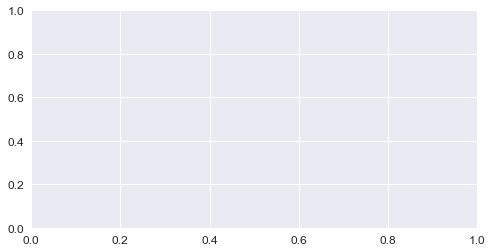

In [54]:
#i+=1
train_model(
    model, 
    dataset, 
    #model_path + name_folder,
    learning_rate=1e-3,
    #log_dir=None#"./logs/H/" + name + "_" + "x".join(list(map(str, structure))) + "_" + str(i)
)